# Quantum neural network

## HW basis

In [1]:
from torch import nn
from scipy.special import comb
from scipy.special import binom
import torch
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from itertools import combinations
from scipy.special import comb
from itertools import combinations

In [2]:
def BSH_Unitary(nbr_state, gate_impact, device):
    """ Return an BSH corresponding unitary decomposed as coeffs that should be multiplied by
    cos(theta), coeffs that should be multiplied by sin(theta) and the ones that are constant
    equal to one. This decomposition allows to avoid inplace operations. 
    Args:
        - nbr_state: size of the considered basis
        - gate impact: list of tuples of basis vectors. Their planar rotation satisfies 
        this transformation
        - device: torch device (cpu, cuda, etc...)
    """
    cos_matrix = torch.zeros((nbr_state,nbr_state), dtype=torch.float32, device=device)
    sin_matrix = torch.zeros((nbr_state,nbr_state), dtype=torch.float32, device=device)
    id_matrix = torch.eye(nbr_state, dtype=torch.uint8, device=device)
    for tuple_states in gate_impact:
        i,j = tuple_states
        id_matrix[i,i] = 0
        id_matrix[j,j] = 0
        cos_matrix[i,i] = 1
        cos_matrix[j,j] = -1
        sin_matrix[i,j] = 1
        sin_matrix[j,i] = 1
    return(cos_matrix, sin_matrix, id_matrix)


def recursive_next_list_BSH(n, k, list_index, index):
    new_list_index = list_index.copy()
    new_list_index[index] += 1
    if (new_list_index[index] // n > 0):
        new_list_index = recursive_next_list_BSH(n - 1, k, new_list_index, index - 1)
        new_list_index[index] = new_list_index[index - 1] + 1
    return (new_list_index)


def dictionary_BSH(n, k):
    """ gives a dictionary that links the state and the list of active bits
    for a k arrangment basis """
    nbr_of_states = int(binom(n, k))
    BSH_dictionary = {}
    for state in range(nbr_of_states):
        if (state == 0):
            BSH_dictionary[state] = [i for i in range(k)]
        else:
            BSH_dictionary[state] = recursive_next_list_BSH(n, k, BSH_dictionary[state - 1], k - 1)
    return (BSH_dictionary)


def map_BSH(n, k):
    """ Given the number of qubits n and the chosen Hamming weight k, outputs
    the corresponding state for a tuple of k active qubits. """
    Dict_BSH = dictionary_BSH(n, k)
    mapping_BSH = {tuple(val): key for (key, val) in Dict_BSH.items()}
    return (mapping_BSH)


def BSH_generalized(a, b, n, k, mapping_BSH):
    """ Given the two qubits a,b the BSH gate is applied on, it outputs a list of
    tuples of basis vectors satisfying this transformation """
    # Selection of all the affected states
    BSH = []
    # List of qubits except a and b:
    list_qubit = [i for i in range(n)]
    list_qubit.pop(max(a, b))
    list_qubit.pop(min(a, b))
    # We create the list of possible active qubit set for this BSH:
    list_combinations = list(combinations(list_qubit, k - 1))
    for element in list_combinations:
        active_qubits_a = sorted([a] + list(element))
        active_qubits_b = sorted([b] + list(element))
        BSH.append((mapping_BSH[tuple(active_qubits_a)], mapping_BSH[tuple(active_qubits_b)]))
    return BSH


def BSH_Unitaries(n, k, list_gates, device):
    """ We store the BSH unitaries corresponding to each edge in the qubit connectivity to
    save memory. This allows to different BSH applied on the same pair of qubit to use the
    same unitary (but different parameters).
    Args:
        - n: nbr of qubits
        - k: chosen Hamming Weight
        - list_gates: list of tuples representing the qubits affected by each BSH
        - device: torch device (cpu, cuda, etc...)
    Output:
        - BSH_Unitaries_dict: a dictionary with key tuples of qubits affected by BSH and
        with values tuples of tensors that decompose the equivalent unitary such as in
        BSH_Unitary (cos_matrix, sin_matrix, id_matrix)
    """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    mapping_BSH = map_BSH(n, k)
    for (i,j) in qubit_edges:
        BSH_Unitaries_dict[(i,j)] = BSH_Unitary(int(binom(n,k)), BSH_generalized(i,j,n,k,mapping_BSH), device)
    return(BSH_Unitaries_dict)


def BSH_generalized_I2_2D(a, b, I):
    """ Given the two qubits a,b the BSH gate is applied on, it outputs a list of
    tuples of basis vectors afffected by a rotation in the basis of IxI images. 
    We suppose that a and b are in the same register (line or column). """
    # Selection of all the affected states
    BSH = []
    if (a < I and b < I):
        # We are in the line register
        for column in range(I):
            BSH.append((a * I + column, b * I + column))
    elif (a >= I and b >= I):
        # We are in the column register
        for line in range(I):
            BSH.append((line * I + a - I, line * I + b - I))
    else:
        # We are in the cross register
        print("Error in BSH_generalized_I2: the two qubits are not in the same register")
    return (BSH)


def BSH_Unitaries_I2(I, list_gates, device):
    """ We store the BSH unitaries corresponding to each edge in the qubit connectivity to
    save memory. This allows to different BSH applied on the same pair of qubit to use the
    same unitary (but different parameters). This function differs from BSH_Unitaries as 
    we consider the basis of the Image.
    Args:
        - I: size of the image
        - list_gates: list of tuples representing the qubits affected by each BSH
        - device: torch device (cpu, cuda, etc...)
    Output:
        - BSH_Unitaries_dict: a dictionary with key tuples of qubits affected by BSH and
        with values tuples of tensors that decompose the equivalen unitary such as in
        BSH_Unitary (cos_matrix, sin_matrix, id_matrix)
    """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    for (i,j) in qubit_edges:
        BSH_Unitaries_dict[(i,j)] = BSH_Unitary(int(I**2), BSH_generalized_I2_2D(i,j,I), device)
    return(BSH_Unitaries_dict)


def unitary_matrix(angle, qubit_tuple, BSH_unitaries):
    return BSH_unitaries[qubit_tuple][0] * torch.cos(angle) + BSH_unitaries[qubit_tuple][1] * torch.sin(angle) + BSH_unitaries[qubit_tuple][2]


def calculate_qfim_and_rank(state_vector, partials):
    """
    QFIM_{i,j} = 4 Re[ <dpsi_i | dpsi_j> - <dpsi_i|psi>*<psi|dpsi_j> ]
    where dpsi_i = d|psi>/dtheta_i.

    'partials' is a list of d|psi>/dtheta_i. 
    If you have D parameters, 'partials' has length D.
    """
    # Number of parameters
    D = len(partials)

    psi = state_vector.to(torch.complex128)
    partials = [p.to(torch.complex128) for p in partials]

    QFIM = torch.zeros((D, D), dtype=torch.float64, device=psi.device)

    # Precompute <psi | dpsi_j>
    psi_conj = psi.conj()
    overlaps_psi_dpsi = []
    for j in range(D):
        overlap_j = torch.sum(psi_conj * partials[j])
        overlaps_psi_dpsi.append(overlap_j)

    for i in range(D):
        dpsi_i = partials[i]
        dpsi_i_conj = dpsi_i.conj()
        overlap_psi_dpsi_i = overlaps_psi_dpsi[i]

        for j in range(D):
            dpsi_j = partials[j]
            overlap_dpsi_i_dpsi_j = torch.sum(dpsi_i_conj * dpsi_j)
            overlap_psi_dpsi_j = overlaps_psi_dpsi[j]

            # QFIM_{i,j} = 4 Re[ <dpsi_i|dpsi_j> - <dpsi_i|psi>*<psi|dpsi_j> ]
            qfim_element = overlap_dpsi_i_dpsi_j - overlap_psi_dpsi_i.conj() * overlap_psi_dpsi_j
            QFIM[i, j] = 4.0 * torch.real(qfim_element)

    rank = torch.linalg.matrix_rank(QFIM).item()
    return QFIM, rank


def circuit(dim_state, angles: torch.Tensor, BSH_unitaries) -> torch.Tensor:
    """
    angles shape = (#gates,).
    Returns the first column of U(angles) as a size-(dk,) state vector.
    """
    U = torch.eye(dim_state, dtype=torch.float32, device=device)
    for gate_idx, qubit_tuple in enumerate(list_gates):
        U = U @ unitary_matrix(angles[gate_idx], qubit_tuple, BSH_unitaries)

    return U[:, 0]  # shape: (dk,)


def circuit_diff_HW(angles: torch.Tensor) -> torch.Tensor:
    U = torch.eye(dim_state, dtype=torch.float32, device=device)
    for gate_idx, qubit_tuple in enumerate(list_gates):
        U = U @ unitary_matrix(angles[gate_idx], qubit_tuple, BSH_unitaries)
    return U[:, 0]  # shape: (dk,)


def circuit_diff_IM(angles: torch.Tensor) -> torch.Tensor:
    U = torch.eye(dim_state, dtype=torch.float32, device=device)
    for gate_idx, qubit_tuple in enumerate(list_gates):
        U = U @ unitary_matrix(angles[gate_idx], qubit_tuple, BSH_unitaries_I2)
    return U[:, 0]  # shape: (dk,)


def get_quantum_loader(number_sample, PCA_data, angles_param, num_epochs, dim_state, BSH_unitaries):
    sum_error = 0
    psi_s = torch.zeros([number_sample,dim_state])
    for sample_idx in range(number_sample):
        m_np = PCA_data[sample_idx]         # shape (10,)
        m = torch.tensor(m_np, dtype=torch.float32)  # shape (10,)
        m = m / (m.norm() + 1e-12)
        m = m.to(device)
        optimizer = optim.Adam([angles_param], lr=0.01)
        loss_fn = nn.MSELoss()

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            psi = circuit(dim_state, angles_param, BSH_unitaries)
            norm_psi = psi.norm().detach()
            if norm_psi.item() > 1e-12:
                psi_normed = psi / norm_psi
            else:
                psi_normed = psi
            loss = loss_fn(psi_normed, m)
            loss.backward()
            optimizer.step()
        # Final evaluation
        psi_final = circuit(dim_state, angles_param, BSH_unitaries).detach()
        psi_final_normed = psi_final / (psi_final.norm() + 1e-12)
        # print(psi_final_normed)
        # print(m)
        final_mse = loss_fn(psi_final_normed, m).item()
        sum_error += final_mse
        
        psi_s[sample_idx] = psi_final_normed
        
    return angles_param.data, sum_error/number_sample, psi_s


def get_PCA_data(n_components):
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    N = 6000  # Typically 60,000
    X_list = []
    for i in range(N):
        img, label = mnist_train[i]  # img is shape (1, 28, 28)
        img_np = img.numpy().squeeze()  # shape (28, 28)
        flattened = img_np.reshape(-1)  # shape (784,)
        X_list.append(flattened)

    X = np.array(X_list, dtype=np.float32)  # shape (N, 784), on CPU
    print(X.shape)
    pca = PCA(n_components=n_components)
    PCA_data = pca.fit_transform(X)  # shape (N, 10)
    return PCA_data


def preprocess_and_pool(data, output_size, device):
    """
    Preprocess and pool MNIST images using AdaptiveAvgPool2d.
    
    Args:
        data (torch.Tensor): Input data of shape (6000, 784).
        output_size (int): Desired output size I for (I, I) pooling.
        device (torch.device): Device to perform computation on (e.g., 'cuda' or 'cpu').
    
    Returns:
        torch.Tensor: Pooled data of shape (6000, I * I).
    """
    # Ensure the data is in the correct shape for MNIST (6000, 28, 28)
    data = data.view(-1, 1, 28, 28)  # Reshape to (6000, 1, 28, 28)

    # Define the adaptive average pooling layer
    adaptive_avg_pool = nn.AdaptiveAvgPool2d((output_size, output_size))

    # Apply pooling
    pooled_data = adaptive_avg_pool(data)

    # Reshape back to (6000, I * I) if needed
    pooled_data = pooled_data.view(-1, output_size * output_size)

    # Move the data to the specified device
    pooled_data = pooled_data.to(device)

    return pooled_data


def get_pooling_data(I):
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    N = 6000  # Typically 60,000
    X_list = []
    for i in range(N):
        img, label = mnist_train[i]  # img is shape (1, 28, 28)
        img_np = img.numpy().squeeze()  # shape (28, 28)
        flattened = img_np.reshape(-1)  # shape (784,)
        X_list.append(flattened)

    X = np.array(X_list, dtype=np.float32)  # shape (N, 784), on CPU
    print(X.shape)
    return preprocess_and_pool(torch.from_numpy(X), I, device)

In [6]:
n = 5
k = 2
# torch.manual_seed(42)
dim_state = (int)(comb(n,k))
device = torch.device("cpu")
# list_gates = [(0,2),(1,3),(0,1),(2,3)]
# list_gates = [(0,2),(1,3),(0,1),(2,3),(0,2),(3,4),(1,3),(0,1),(2,3)]
list_gates =  [(0,2),(1,3),(0,1),(2,3),(0,2),(3,4),(1,3),(0,1),(2,3),(3,4),(1,3)]
BSH_unitaries = BSH_Unitaries(n, k, list_gates, device)
angles_param = nn.Parameter(torch.rand((len(list_gates),), device=device))

state_vector = circuit(dim_state, angles_param, BSH_unitaries)  # shape: (dk,)
partial_matrix = torch.autograd.functional.jacobian(circuit_diff_HW, angles_param)
partials = []
for p in range(partial_matrix.shape[1]):
    dpsi_p = partial_matrix[:, p]
    partials.append(dpsi_p)

QFIM, rank = calculate_qfim_and_rank(state_vector, partials)

print(f"Number of gates (parameters) = {len(list_gates)} => QFIM is {QFIM.shape}")
print("Rank of QFIM:", rank)

Number of gates (parameters) = 11 => QFIM is torch.Size([11, 11])
Rank of QFIM: 9


In [7]:
n = 5
k = 2
device = torch.device("cpu")  # or 'cuda' if you have a GPU
dim_state = int(comb(n, k))  # should be 10
# list_gates = [(0,2)]
list_gates = [(0,2),(1,3),(0,1),(2,3),(0,2),(3,4),(1,3),(0,1),(2,3)]
# list_gates = [(0,2),(1,3),(0,1),(2,3),(0,2),(3,4),(1,3),(0,1),(2,3),(3,4),(1,3)]
BSH_unitaries = BSH_Unitaries(n, k, list_gates, device)
angles_param = nn.Parameter(torch.rand(len(list_gates), device=device))
number_sample = 100
num_epochs = 100
n_components = dim_state
PCA_data = get_PCA_data(n_components)
# print(PCA_data.shape)
angles, averge_error, psi_final = get_quantum_loader(number_sample, PCA_data, angles_param, num_epochs, dim_state, BSH_unitaries)
# print(angles)
print(averge_error)
# plt.imshow(psi_final.view(number_sample,dim_state,I)[0])
# plt.show()

(6000, 784)
0.03571561756194569


In [339]:
# from src.toolbox import PQNN_building_brick
# 
# 
# def full_pyramid_circuit(n, start_point):
#     """ n=8
#     0: ─╭B────╭B────╭B────╭B────╭B────╭B────╭B─┤
#     1: ─╰S─╭B─╰S─╭B─╰S─╭B─╰S─╭B─╰S─╭B─╰S─╭B─╰S─┤
#     2: ────╰S─╭B─╰S─╭B─╰S─╭B─╰S─╭B─╰S─╭B─╰S────┤
#     3: ───────╰S─╭B─╰S─╭B─╰S─╭B─╰S─╭B─╰S───────┤
#     4: ──────────╰S─╭B─╰S─╭B─╰S─╭B─╰S──────────┤
#     5: ─────────────╰S─╭B─╰S─╭B─╰S─────────────┤
#     6: ────────────────╰S─╭B─╰S────────────────┤
#     7: ───────────────────╰S───────────────────┤
#     """
#     list_gates = []
#     _, PQNN_dictionary, _ = PQNN_building_brick(start_point, n, index_first_RBS=0, index_first_param=0)
#     for key in PQNN_dictionary:
#         list_gates.append(PQNN_dictionary[key])
#     return list_gates

In [340]:
# n = 6
# I = n//2
# dim_state = I*I
# device = torch.device("cpu")
# list_gates =  full_pyramid_circuit(I, 0)
# # list_gates =  full_pyramid_circuit(I, 0) + full_pyramid_circuit(I, I)
# BSH_unitaries_I2 = BSH_Unitaries_I2(n//2, list_gates, device)
# angles_param = nn.Parameter(torch.rand((len(list_gates),), device=device))
# 
# state_vector = circuit(dim_state, angles_param, BSH_unitaries_I2)  # shape: (dk,)
# print("state: " + str(state_vector.shape))
# partial_matrix = torch.autograd.functional.jacobian(circuit_diff_IM, angles_param)
# partials = []
# for p in range(partial_matrix.shape[1]):
#     dpsi_p = partial_matrix[:, p]
#     partials.append(dpsi_p)
# 
# QFIM, rank = calculate_qfim_and_rank(state_vector, partials)
# 
# print(f"Number of gates (parameters) = {len(list_gates)} => QFIM is {QFIM.shape}")
# print("Rank of QFIM:", rank)

state: torch.Size([9])
Number of gates (parameters) = 3 => QFIM is torch.Size([3, 3])
Rank of QFIM: 2


In [341]:
# n = 6
# I = n//2
# dim_state = I*I
# device = torch.device("cpu")
# list_gates =  full_pyramid_circuit(I, 0)
# # list_gates =  full_pyramid_circuit(I, 0) + full_pyramid_circuit(I, I)
# BSH_unitaries_I2 = BSH_Unitaries_I2(n//2, list_gates, device)
# angles_param = nn.Parameter(torch.rand(len(list_gates), device=device))
# number_sample = 100
# num_epochs = 100
# n_components = dim_state
# PCA_data = get_PCA_data(n_components)
# angles, averge_error, psi_final_normed = get_quantum_loader(number_sample, PCA_data, angles_param, num_epochs, dim_state, BSH_unitaries_I2)
# print(PCA_data.shape)
# # print(angles)
# print(averge_error)

(6000, 784)
(6000, 9)
0.09614664476364851


(6000, 784)


/Users/letao/anaconda3/envs/env3.7/lib/python3.7/site-packages/ipykernel_launcher.py:210: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([100, 9])


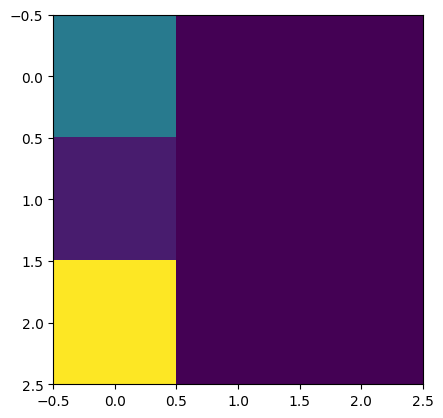

0.17800691179931163


In [344]:
# from matplotlib import pyplot as plt
# 
# n = 6
# I = n//2
# dim_state = I*I
# device = torch.device("cpu")
# list_gates =  full_pyramid_circuit(I, 0)
# # list_gates =  full_pyramid_circuit(I, 0) + full_pyramid_circuit(I, I)
# BSH_unitaries_I2 = BSH_Unitaries_I2(n//2, list_gates, device)
# angles_param = nn.Parameter(torch.rand(len(list_gates), device=device))
# number_sample = 100
# num_epochs = 100
# pooling_data = get_pooling_data(I)
# angles, averge_error, psi_final = get_quantum_loader(number_sample, pooling_data, angles_param, num_epochs, dim_state, BSH_unitaries_I2)
# # print(pooling_data.shape)
# # print(angles)
# print(psi_final.shape)
# plt.imshow(psi_final.view(number_sample,I,I)[0])
# plt.show()
# print(averge_error)

# Symbolic

In [148]:
from itertools import combinations
from sympy import symbols, Matrix, sin, cos, eye, binomial, diff, simplify


def BSH_Unitary_sym(nbr_state, gate_impact):
    """ Symbolic BSH unitary decomposition. """
    cos_matrix = Matrix.zeros(nbr_state, nbr_state)
    sin_matrix = Matrix.zeros(nbr_state, nbr_state)
    id_matrix = eye(nbr_state)
    for tuple_states in gate_impact:
        i, j = tuple_states
        id_matrix[i, i] = 0
        id_matrix[j, j] = 0
        cos_matrix[i, i] = 1
        cos_matrix[j, j] = 1
        sin_matrix[i, j] = 1
        sin_matrix[j, i] = -1
    return cos_matrix, sin_matrix, id_matrix

def recursive_next_list_BSH(n, k, list_index, index):
    new_list_index = list_index.copy()
    new_list_index[index] += 1
    if new_list_index[index] // n > 0:
        new_list_index = recursive_next_list_BSH(n - 1, k, new_list_index, index - 1)
        new_list_index[index] = new_list_index[index - 1] + 1
    return new_list_index

def dictionary_BSH(n, k):
    """ Symbolic state dictionary. """
    nbr_of_states = int(binomial(n, k))
    BSH_dictionary = {}
    for state in range(nbr_of_states):
        if state == 0:
            BSH_dictionary[state] = [i for i in range(k)]
        else:
            BSH_dictionary[state] = recursive_next_list_BSH(n, k, BSH_dictionary[state - 1], k - 1)
    return BSH_dictionary

def map_BSH(n, k):
    """ Mapping symbolic states to indices. """
    Dict_BSH = dictionary_BSH(n, k)
    mapping_BSH = {tuple(val): key for (key, val) in Dict_BSH.items()}
    return mapping_BSH

def BSH_generalized_sym(a, b, n, k, mapping_BSH):
    """ Symbolic BSH gate generation. """
    BSH = []
    list_qubit = [i for i in range(n)]
    list_qubit.pop(max(a, b))
    list_qubit.pop(min(a, b))
    list_combinations = list(combinations(list_qubit, k - 1))
    for element in list_combinations:
        active_qubits_a = sorted([a] + list(element))
        active_qubits_b = sorted([b] + list(element))
        BSH.append((mapping_BSH[tuple(active_qubits_a)], mapping_BSH[tuple(active_qubits_b)]))
    return BSH

def BSH_Unitaries_sym(n, k, list_gates):
    """ Symbolic unitaries for BSH gates. """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    mapping_BSH = map_BSH(n, k)
    for (i, j) in qubit_edges:
        BSH_Unitaries_dict[(i, j)] = BSH_Unitary_sym(int(binomial(n, k)), BSH_generalized_sym(i, j, n, k, mapping_BSH))
    return BSH_Unitaries_dict


def BSH_generalized_I2_2D_sym(a, b, I):
    """ Symbolic BSH gate for 2D image basis. """
    BSH = []
    if a < I and b < I:
        # Line register
        for column in range(I):
            BSH.append((a * I + column, b * I + column))
    elif a >= I and b >= I:
        # Column register
        for line in range(I):
            BSH.append((line * I + a - I, line * I + b - I))
    else:
        raise ValueError("Error in BSH_generalized_I2_2D_sym: the two qubits are not in the same register")
    return BSH


def BSH_Unitaries_I2_sym(I, list_gates):
    """ Symbolic BSH unitaries for 2D image basis. """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    for (i, j) in qubit_edges:
        BSH_Unitaries_dict[(i, j)] = BSH_Unitary_sym(I**2, BSH_generalized_I2_2D_sym(i, j, I))
    return BSH_Unitaries_dict


def unitary_matrix_sym(angle, qubit_tuple, BSH_unitaries):
    cos_matrix, sin_matrix, id_matrix = BSH_unitaries[qubit_tuple]
    return cos_matrix * cos(angle) + sin_matrix * sin(angle) + id_matrix

# Example usage
n = 5
k = 2
# list_gates = [(0, 1)]
list_gates = [(0,2),(1,3),(0,1),(2,3),(0,2),(3,4),(1,3),(0,1),(2,3)]
angles = symbols(f'theta_0:{len(list_gates)}')
BSH_unitaries = BSH_Unitaries_sym(n, k, list_gates)

# Initialize identity matrix for the unitary
U = eye(int(binomial(n, k)))
for idx, qubit_tuple in enumerate(list_gates):
    U = U @ unitary_matrix_sym(angles[idx], qubit_tuple, BSH_unitaries)
# display(U)

first_column = U[:, 0]

# display(first_column)

# Compute the Jacobian matrix without simplifications
Jacobian = Matrix([[diff(first_column[i], angle) for angle in angles] for i in range(n)])

# Substitute numerical values into Jacobian for faster numerical rank computation
# Example: substituting all angles to 0.5 radians
subs = {f"theta_{i}": 0.5 for i in range(len(list_gates))}
Jacobian_numeric = Jacobian.subs(subs)

# Compute the QFIM numerically
QFIM_numeric = Jacobian_numeric.T * Jacobian_numeric

# Compute the rank numerically
QFIM_rank = QFIM_numeric.rank()

print("Numerical QFIM Rank:", QFIM_rank)



Numerical QFIM Rank: 7


In [158]:
from sympy import symbols, Matrix, sin, cos, eye, binomial, diff, re
from itertools import combinations

def BSH_Unitary_sym(nbr_state, gate_impact):
    """ Symbolic BSH unitary decomposition. """
    cos_matrix = Matrix.zeros(nbr_state, nbr_state)
    sin_matrix = Matrix.zeros(nbr_state, nbr_state)
    id_matrix = eye(nbr_state)
    for tuple_states in gate_impact:
        i, j = tuple_states
        id_matrix[i, i] = 0
        id_matrix[j, j] = 0
        cos_matrix[i, i] = 1
        cos_matrix[j, j] = -1
        sin_matrix[i, j] = 1
        sin_matrix[j, i] = 1
    return cos_matrix, sin_matrix, id_matrix

def recursive_next_list_BSH(n, k, list_index, index):
    new_list_index = list_index.copy()
    new_list_index[index] += 1
    if new_list_index[index] // n > 0:
        new_list_index = recursive_next_list_BSH(n - 1, k, new_list_index, index - 1)
        new_list_index[index] = new_list_index[index - 1] + 1
    return new_list_index

def dictionary_BSH(n, k):
    """ Symbolic state dictionary. """
    nbr_of_states = int(binomial(n, k))
    BSH_dictionary = {}
    for state in range(nbr_of_states):
        if state == 0:
            BSH_dictionary[state] = [i for i in range(k)]
        else:
            BSH_dictionary[state] = recursive_next_list_BSH(n, k, BSH_dictionary[state - 1], k - 1)
    return BSH_dictionary

def map_BSH(n, k):
    """ Mapping symbolic states to indices. """
    Dict_BSH = dictionary_BSH(n, k)
    mapping_BSH = {tuple(val): key for (key, val) in Dict_BSH.items()}
    return mapping_BSH

def BSH_generalized_sym(a, b, n, k, mapping_BSH):
    """ Symbolic BSH gate generation. """
    BSH = []
    list_qubit = [i for i in range(n)]
    list_qubit.pop(max(a, b))
    list_qubit.pop(min(a, b))
    list_combinations = list(combinations(list_qubit, k - 1))
    for element in list_combinations:
        active_qubits_a = sorted([a] + list(element))
        active_qubits_b = sorted([b] + list(element))
        BSH.append((mapping_BSH[tuple(active_qubits_a)], mapping_BSH[tuple(active_qubits_b)]))
    return BSH

def BSH_Unitaries_sym(n, k, list_gates):
    """ Symbolic unitaries for BSH gates. """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    mapping_BSH = map_BSH(n, k)
    for (i, j) in qubit_edges:
        BSH_Unitaries_dict[(i, j)] = BSH_Unitary_sym(int(binomial(n, k)), BSH_generalized_sym(i, j, n, k, mapping_BSH))
    return BSH_Unitaries_dict

def BSH_generalized_I2_2D_sym(a, b, I):
    """ Symbolic BSH gate for 2D image basis. """
    BSH = []
    if a < I and b < I:
        # Line register
        for column in range(I):
            BSH.append((a * I + column, b * I + column))
    elif a >= I and b >= I:
        # Column register
        for line in range(I):
            BSH.append((line * I + a - I, line * I + b - I))
    else:
        raise ValueError("Error in BSH_generalized_I2_2D_sym: the two qubits are not in the same register")
    return BSH

def BSH_Unitaries_I2_sym(I, list_gates):
    """ Symbolic BSH unitaries for 2D image basis. """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    for (i, j) in qubit_edges:
        BSH_Unitaries_dict[(i, j)] = BSH_Unitary_sym(I**2, BSH_generalized_I2_2D_sym(i, j, I))
    return BSH_Unitaries_dict

def unitary_matrix_sym(angle, qubit_tuple, BSH_unitaries):
    cos_matrix, sin_matrix, id_matrix = BSH_unitaries[qubit_tuple]
    return cos_matrix * cos(angle) + sin_matrix * sin(angle) + id_matrix

def compute_QFIM(U, angles):
    """ Compute the QFIM rank from the first column of U. """
    # Extract the first column of U
    psi = U[:, 0]
    D = len(angles)

    # Compute partial derivatives
    partial_derivatives = [psi.diff(angle) for angle in angles]

    # Initialize QFIM matrix
    QFIM = Matrix.zeros(D, D)

    for i in range(D):
        for j in range(D):
            term1 = re(partial_derivatives[i].dot(partial_derivatives[j].conjugate()))
            term2 = re(partial_derivatives[i].dot(psi.conjugate()) * psi.dot(partial_derivatives[j].conjugate()))
            QFIM[i, j] = 4 * (term1 - term2)

    # Calculate the rank of QFIM
    rank = QFIM.rank()
    return QFIM, rank

# Example usage
n = 5
k = 2
list_gates = [(0,2),(1,3),(0,1),(2,3),(0,2),(3,4),(1,3),(0,1),(2,3)]
I = n // 2
angles = symbols(f'theta_0:{len(list_gates)}')  # Define a unique angle for each gate
BSH_unitaries = BSH_Unitaries_sym(n, k, list_gates)

# Initialize identity matrix for the unitary
U = eye(dk)
for idx, qubit_tuple in enumerate(list_gates):
    U = U @ unitary_matrix_sym(angles[idx], qubit_tuple, BSH_unitaries)

# Compute QFIM and its rank
QFIM, rank = compute_QFIM(U, angles)
print("QFIM:")
print(QFIM)
print("Rank:", rank)


KeyboardInterrupt: 

In [160]:
import numpy as np

# Define the numerical first derivative function
def numerical_derivative(U_func, angles, idx, delta=1e-5):
    """Compute the numerical derivative of U(angles) w.r.t. angles[idx]."""
    angles_forward = angles.copy()
    angles_backward = angles.copy()
    angles_forward[idx] += delta
    angles_backward[idx] -= delta
    U_forward = U_func(angles_forward)
    U_backward = U_func(angles_backward)
    return (U_forward - U_backward) / (2 * delta)

# Define the QFIM calculation
def compute_QFIM(U_func, angles):
    """Calculate the QFIM for the first column of U."""
    D = len(angles)  # Number of variational parameters
    U = U_func(angles)
    psi = U[:, 0]  # First column of U, corresponds to |ψ_s(Θ)>
    QFIM = np.zeros((D, D), dtype=np.float)

    # Compute derivatives
    derivatives = [numerical_derivative(U_func, angles, i)[:, 0] for i in range(D)]

    for i in range(D):
        for j in range(D):
            partial_i = derivatives[i]
            partial_j = derivatives[j]
            inner_product = np.vdot(partial_i, partial_j)
            overlap_i = np.vdot(partial_i, psi)
            overlap_j = np.vdot(partial_j, psi)
            QFIM[i, j] = 4 * (np.real(inner_product) - np.real(overlap_i * np.conj(overlap_j)))
    return QFIM

# Example: Define a unitary function for numerical evaluation
def U_func(angles):
    """Example function to return U(angles)."""
    symbolic_angles = angles  # Replace with numerical angles if necessary
    U_numeric = np.array(U.subs({angles[i]: symbolic_angles[i] for i in range(len(angles))})).astype(np.complex128)
    return U_numeric

# Initialize parameters
D = len(list_gates)
angles_numeric = np.random.rand(D)  # Random angles for demonstration

# Compute the QFIM
QFIM = compute_QFIM(U_func, angles_numeric)

# Calculate the rank of the QFIM
QFIM_rank = np.linalg.matrix_rank(QFIM)

QFIM_rank


TypeError: Cannot convert expression to float

In [109]:
from sympy import symbols, Matrix, sin, cos, eye, binomial
from itertools import combinations
from src.list_gates import full_pyramid_circuit
from sympy import symbols, Matrix, sin, cos, eye, binomial, diff, simplify
from itertools import combinations

def BSH_Unitary_sym(nbr_state, gate_impact):
    """ Symbolic BSH unitary decomposition. """
    cos_matrix = Matrix.zeros(nbr_state, nbr_state)
    sin_matrix = Matrix.zeros(nbr_state, nbr_state)
    id_matrix = eye(nbr_state)
    for tuple_states in gate_impact:
        i, j = tuple_states
        id_matrix[i, i] = 0
        id_matrix[j, j] = 0
        cos_matrix[i, i] = 1
        cos_matrix[j, j] = -1
        sin_matrix[i, j] = 1
        sin_matrix[j, i] = 1
    return cos_matrix, sin_matrix, id_matrix

def recursive_next_list_BSH(n, k, list_index, index):
    new_list_index = list_index.copy()
    new_list_index[index] += 1
    if new_list_index[index] // n > 0:
        new_list_index = recursive_next_list_BSH(n - 1, k, new_list_index, index - 1)
        new_list_index[index] = new_list_index[index - 1] + 1
    return new_list_index

def dictionary_BSH(n, k):
    """ Symbolic state dictionary. """
    nbr_of_states = int(binomial(n, k))
    BSH_dictionary = {}
    for state in range(nbr_of_states):
        if state == 0:
            BSH_dictionary[state] = [i for i in range(k)]
        else:
            BSH_dictionary[state] = recursive_next_list_BSH(n, k, BSH_dictionary[state - 1], k - 1)
    return BSH_dictionary

def map_BSH(n, k):
    """ Mapping symbolic states to indices. """
    Dict_BSH = dictionary_BSH(n, k)
    mapping_BSH = {tuple(val): key for (key, val) in Dict_BSH.items()}
    return mapping_BSH

def BSH_generalized_sym(a, b, n, k, mapping_BSH):
    """ Symbolic BSH gate generation. """
    BSH = []
    list_qubit = [i for i in range(n)]
    list_qubit.pop(max(a, b))
    list_qubit.pop(min(a, b))
    list_combinations = list(combinations(list_qubit, k - 1))
    for element in list_combinations:
        active_qubits_a = sorted([a] + list(element))
        active_qubits_b = sorted([b] + list(element))
        BSH.append((mapping_BSH[tuple(active_qubits_a)], mapping_BSH[tuple(active_qubits_b)]))
    return BSH

def BSH_Unitaries_sym(n, k, list_gates):
    """ Symbolic unitaries for BSH gates. """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    mapping_BSH = map_BSH(n, k)
    for (i, j) in qubit_edges:
        BSH_Unitaries_dict[(i, j)] = BSH_Unitary_sym(int(binomial(n, k)), BSH_generalized_sym(i, j, n, k, mapping_BSH))
    return BSH_Unitaries_dict

def BSH_generalized_I2_2D_sym(a, b, I):
    """ Symbolic BSH gate for 2D image basis. """
    BSH = []
    if a < I and b < I:
        # Line register
        for column in range(I):
            BSH.append((a * I + column, b * I + column))
    elif a >= I and b >= I:
        # Column register
        for line in range(I):
            BSH.append((line * I + a - I, line * I + b - I))
    else:
        raise ValueError("Error in BSH_generalized_I2_2D_sym: the two qubits are not in the same register")
    return BSH

def BSH_Unitaries_I2_sym(I, list_gates):
    """ Symbolic BSH unitaries for 2D image basis. """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    for (i, j) in qubit_edges:
        BSH_Unitaries_dict[(i, j)] = BSH_Unitary_sym(I**2, BSH_generalized_I2_2D_sym(i, j, I))
    return BSH_Unitaries_dict

def unitary_matrix_sym(angle, qubit_tuple, BSH_unitaries):
    cos_matrix, sin_matrix, id_matrix = BSH_unitaries[qubit_tuple]
    return cos_matrix * cos(angle) + sin_matrix * sin(angle) + id_matrix

# Example usage
n = 4
k = 2
list_gates = [(0, 1), (2, 3)]
I = n // 2
angles = symbols(f'theta_0:{len(list_gates)}')  # Define a unique angle for each gate
BSH_unitaries = BSH_Unitaries_I2_sym(I, list_gates)

# Initialize identity matrix for the unitary
U = eye(n)
for idx, qubit_tuple in enumerate(list_gates):
    U = U @ unitary_matrix_sym(angles[idx], qubit_tuple, BSH_unitaries)

display(U)

# Select the first column of U
first_column = U[:, 0]

# Compute the Jacobian (gradient of the first column w.r.t. angles)
Jacobian = Matrix([[simplify(diff(first_column[i], angle)) for angle in angles] for i in range(n)])

# Compute the QFIM
QFIM = Jacobian.T * Jacobian

# Compute the rank of QFIM
QFIM_rank = QFIM.rank()
display(first_column)
print("QFIM Rank:", QFIM_rank)


Matrix([
[cos(theta_0)*cos(theta_1),  sin(theta_1)*cos(theta_0),  sin(theta_0)*cos(theta_1),  sin(theta_0)*sin(theta_1)],
[sin(theta_1)*cos(theta_0), -cos(theta_0)*cos(theta_1),  sin(theta_0)*sin(theta_1), -sin(theta_0)*cos(theta_1)],
[sin(theta_0)*cos(theta_1),  sin(theta_0)*sin(theta_1), -cos(theta_0)*cos(theta_1), -sin(theta_1)*cos(theta_0)],
[sin(theta_0)*sin(theta_1), -sin(theta_0)*cos(theta_1), -sin(theta_1)*cos(theta_0),  cos(theta_0)*cos(theta_1)]])

Matrix([
[cos(theta_0)*cos(theta_1)],
[sin(theta_1)*cos(theta_0)],
[sin(theta_0)*cos(theta_1)],
[sin(theta_0)*sin(theta_1)]])

QFIM Rank: 2


In [108]:
from src.list_gates import full_pyramid_circuit
from sympy import symbols, Matrix, sin, cos, eye, binomial, diff, simplify
from itertools import combinations

def BSH_Unitary_sym(nbr_state, gate_impact):
    """ Symbolic BSH unitary decomposition. """
    cos_matrix = Matrix.zeros(nbr_state, nbr_state)
    sin_matrix = Matrix.zeros(nbr_state, nbr_state)
    id_matrix = eye(nbr_state)
    for tuple_states in gate_impact:
        i, j = tuple_states
        id_matrix[i, i] = 0
        id_matrix[j, j] = 0
        cos_matrix[i, i] = 1
        cos_matrix[j, j] = -1
        sin_matrix[i, j] = 1
        sin_matrix[j, i] = 1
    return cos_matrix, sin_matrix, id_matrix

def recursive_next_list_BSH(n, k, list_index, index):
    new_list_index = list_index.copy()
    new_list_index[index] += 1
    if new_list_index[index] // n > 0:
        new_list_index = recursive_next_list_BSH(n - 1, k, new_list_index, index - 1)
        new_list_index[index] = new_list_index[index - 1] + 1
    return new_list_index

def dictionary_BSH(n, k):
    """ Symbolic state dictionary. """
    nbr_of_states = int(binomial(n, k))
    BSH_dictionary = {}
    for state in range(nbr_of_states):
        if state == 0:
            BSH_dictionary[state] = [i for i in range(k)]
        else:
            BSH_dictionary[state] = recursive_next_list_BSH(n, k, BSH_dictionary[state - 1], k - 1)
    return BSH_dictionary

def map_BSH(n, k):
    """ Mapping symbolic states to indices. """
    Dict_BSH = dictionary_BSH(n, k)
    mapping_BSH = {tuple(val): key for (key, val) in Dict_BSH.items()}
    return mapping_BSH

def BSH_generalized_sym(a, b, n, k, mapping_BSH):
    """ Symbolic BSH gate generation. """
    BSH = []
    list_qubit = [i for i in range(n)]
    list_qubit.pop(max(a, b))
    list_qubit.pop(min(a, b))
    list_combinations = list(combinations(list_qubit, k - 1))
    for element in list_combinations:
        active_qubits_a = sorted([a] + list(element))
        active_qubits_b = sorted([b] + list(element))
        BSH.append((mapping_BSH[tuple(active_qubits_a)], mapping_BSH[tuple(active_qubits_b)]))
    return BSH

def BSH_Unitaries_sym(n, k, list_gates):
    """ Symbolic unitaries for BSH gates. """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    mapping_BSH = map_BSH(n, k)
    for (i, j) in qubit_edges:
        BSH_Unitaries_dict[(i, j)] = BSH_Unitary_sym(int(binomial(n, k)), BSH_generalized_sym(i, j, n, k, mapping_BSH))
    return BSH_Unitaries_dict

def BSH_generalized_I2_2D_sym(a, b, I):
    """ Symbolic BSH gate for 2D image basis. """
    BSH = []
    if a < I and b < I:
        # Line register
        for column in range(I):
            BSH.append((a * I + column, b * I + column))
    elif a >= I and b >= I:
        # Column register
        for line in range(I):
            BSH.append((line * I + a - I, line * I + b - I))
    else:
        raise ValueError("Error in BSH_generalized_I2_2D_sym: the two qubits are not in the same register")
    return BSH

def BSH_Unitaries_I2_sym(I, list_gates):
    """ Symbolic BSH unitaries for 2D image basis. """
    BSH_Unitaries_dict, qubit_edges = {}, list(set(list_gates))
    for (i, j) in qubit_edges:
        BSH_Unitaries_dict[(i, j)] = BSH_Unitary_sym(I**2, BSH_generalized_I2_2D_sym(i, j, I))
    return BSH_Unitaries_dict

def unitary_matrix_sym(angle, qubit_tuple, BSH_unitaries):
    cos_matrix, sin_matrix, id_matrix = BSH_unitaries[qubit_tuple]
    return cos_matrix * cos(angle) + sin_matrix * sin(angle) + id_matrix

# Example usage
n = 3
list_gates = [(0,1),(0,2),(1,3),(2,3),(3,4)]
# list_gates = [(0,1),(1,2),(0,1),(2,3),(1,2),(0,1),(4,5),(5,6),(4,5),(6,7),(5,6),(4,5)]
# list_gates = full_pyramid_circuit(n) 
I = n // 2
angles = symbols(f'theta_0:{len(list_gates)}')  # Define a unique angle for each gate
BSH_unitaries = BSH_Unitaries_I2_sym(I, list_gates)

# Initialize identity matrix for the unitary
U = eye(I*I)
for idx, qubit_tuple in enumerate(list_gates):
    U = U @ unitary_matrix_sym(angles[idx], qubit_tuple, BSH_unitaries)

# Select the first column of U
first_column = U[:, 0]

# Compute the Jacobian (gradient of the first column w.r.t. angles)
Jacobian = Matrix([[simplify(diff(first_column[i], angle)) for angle in angles] for i in range(n)])

# Compute the QFIM
QFIM = Jacobian.T * Jacobian

# Compute the rank of QFIM
QFIM_rank = QFIM.rank()
display(first_column)
print("QFIM Rank:", QFIM_rank)


KeyboardInterrupt: 